In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import resample, class_weight

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2


from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('Telco-Customer-Churn.csv')


print(data.head())

data.info()

print(data.isnull().sum())

print(data.describe(include='all'))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [3]:
# Eksik verilerin giderilmesi
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Kategorik değişkenlerin dönüştürülmesi (Evet/Hayır => 1/0)
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Kategorik ve sayısal değişkenlerin tanımlanması
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in data.columns if col not in numeric_features + ['customerID', 'Churn']]

# Kategorik değişkenleri sayısal etiketlere çevirin
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

 Müşteri Kaybı (Churn) Dağılımı

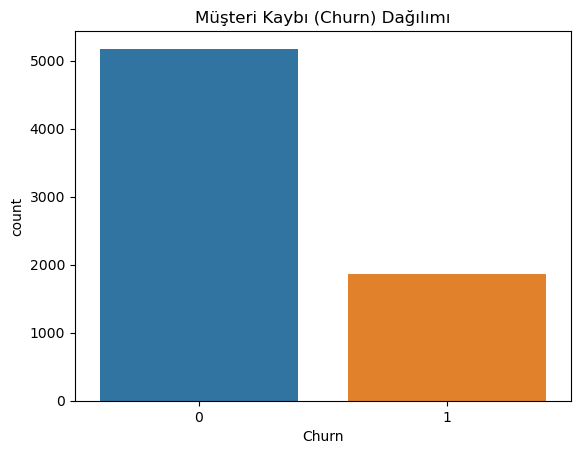

In [4]:
# Müşteri Kaybı (Churn) dağılımı
sns.countplot(x='Churn', data=data)
plt.title('Müşteri Kaybı (Churn) Dağılımı')
plt.show()

Sayısal Değişkenlerin Dağılımı

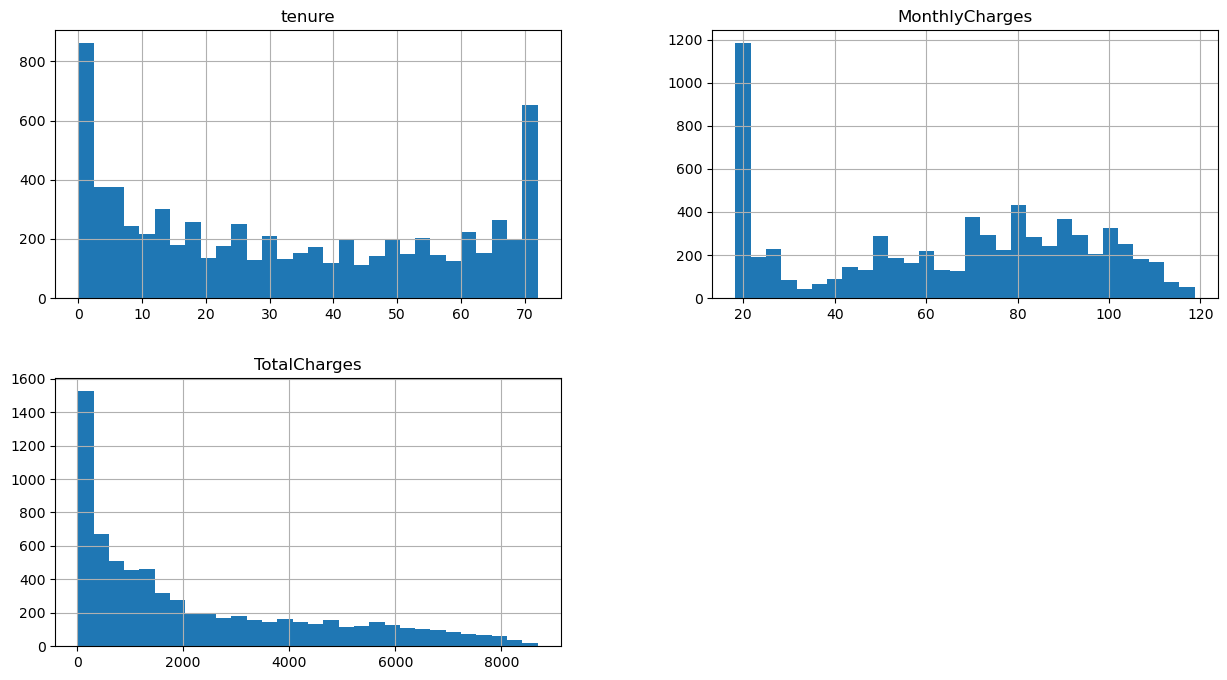

In [5]:
# Sayısal değişkenlerin dağılımını inceleyin
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
data[numeric_features].hist(bins=30, figsize=(15, 8))
plt.show()

Kategorik Değişkenlerin Dağılımı

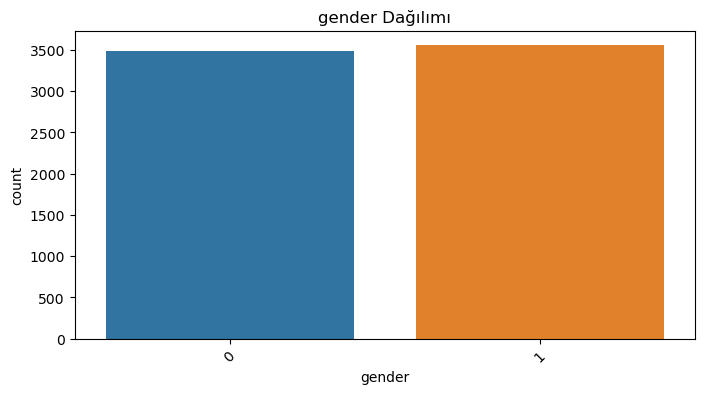

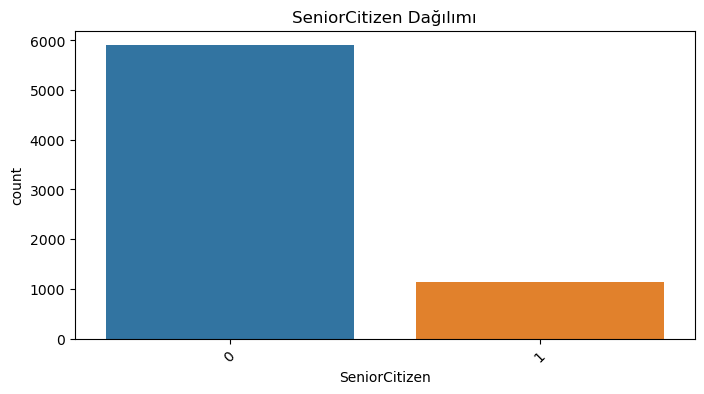

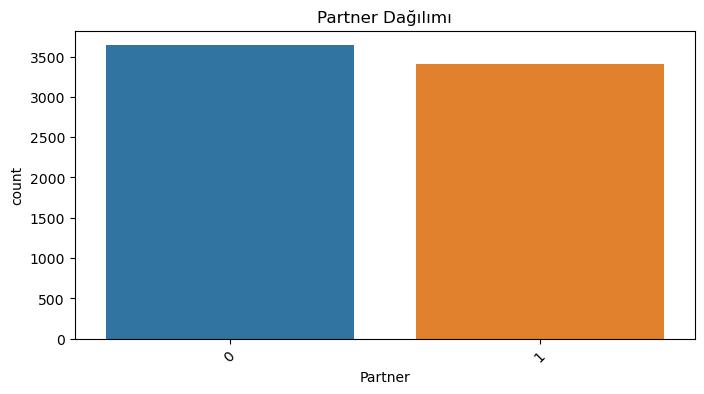

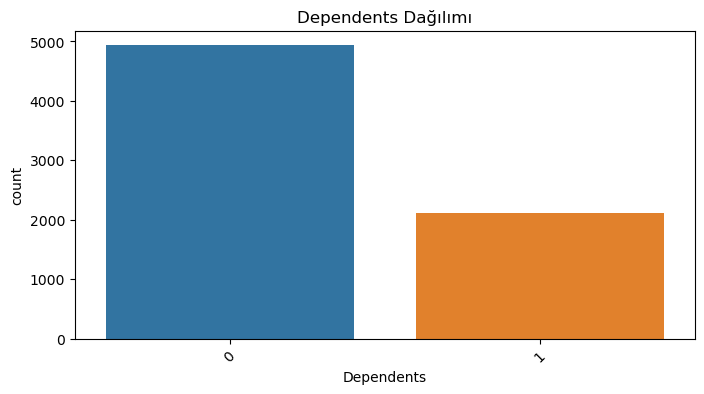

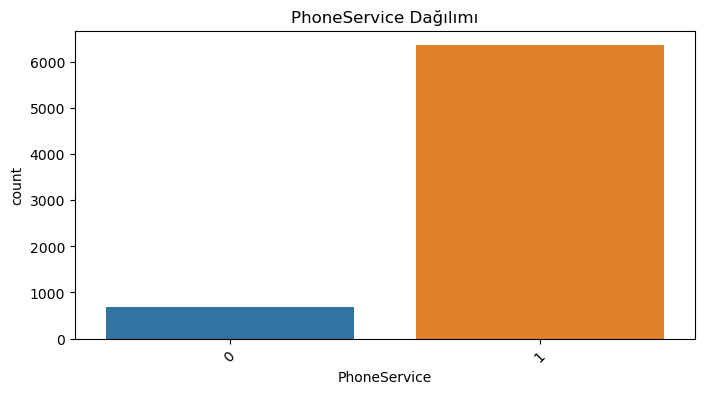

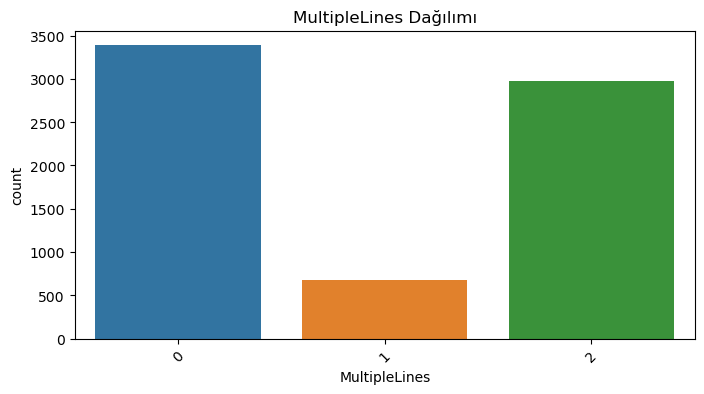

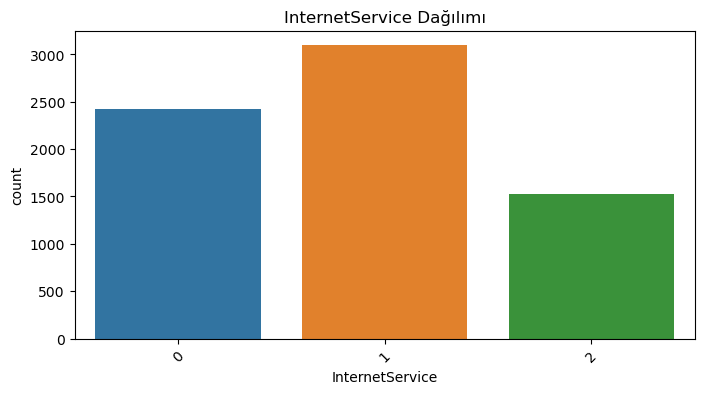

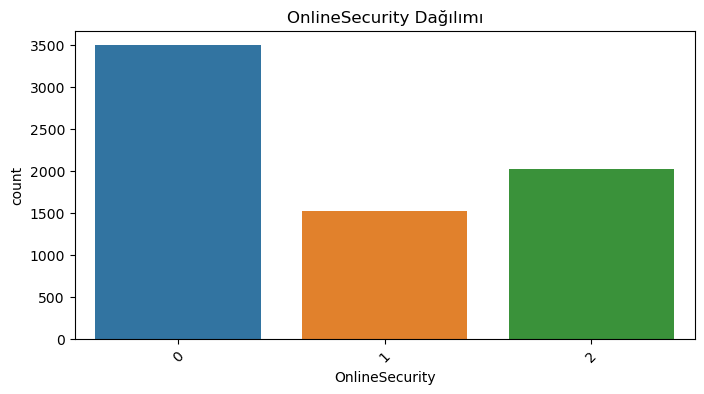

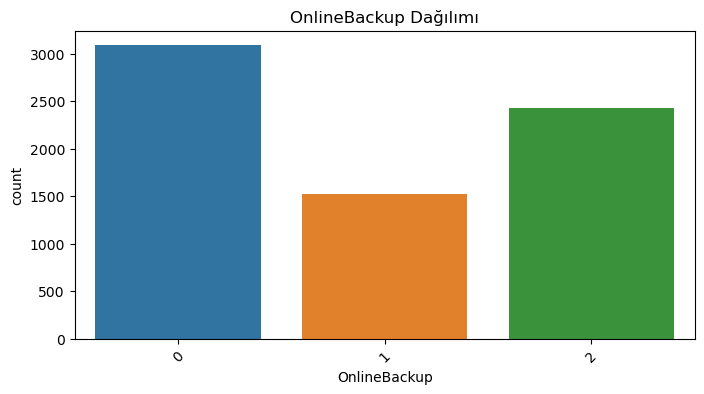

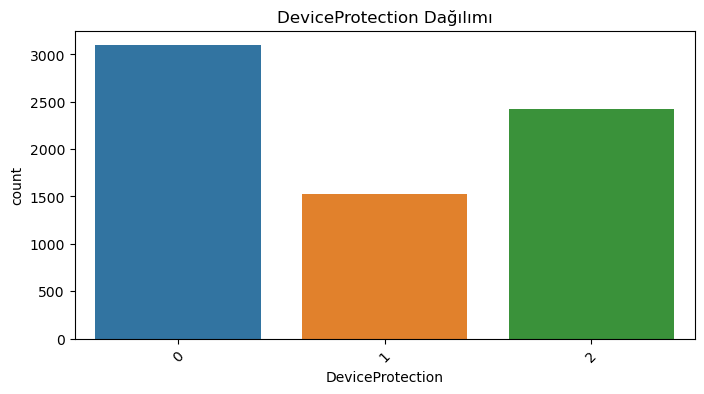

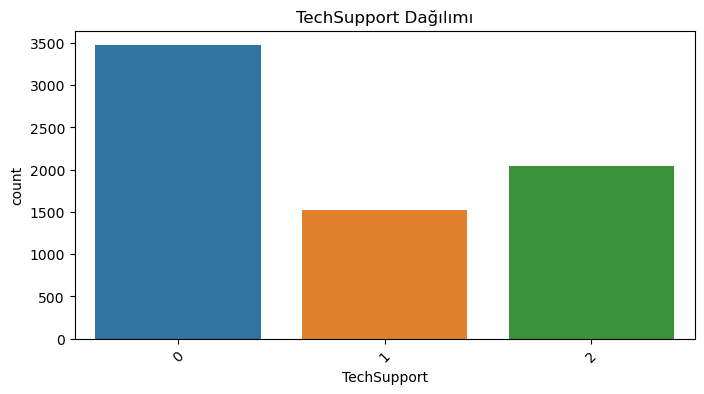

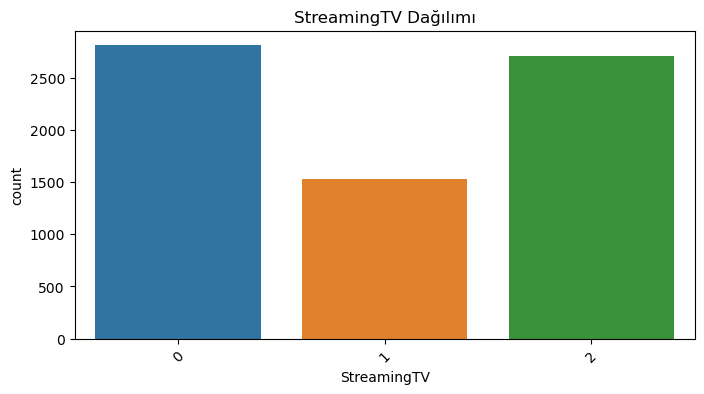

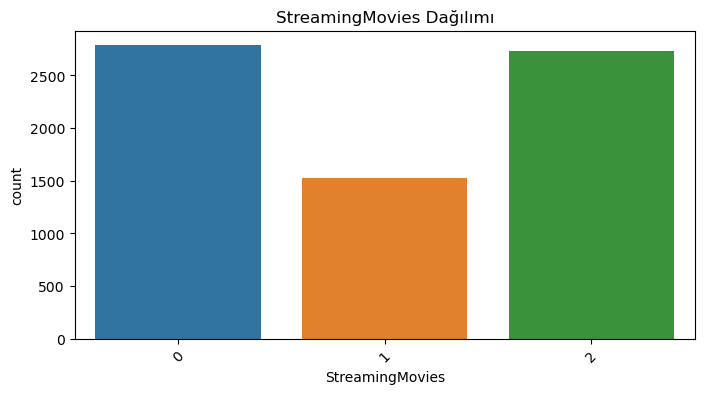

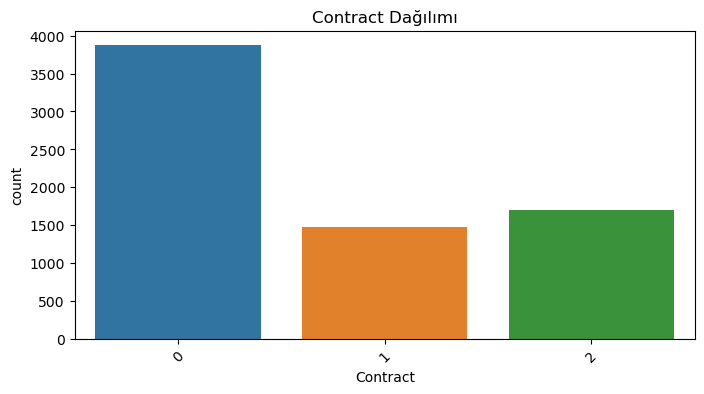

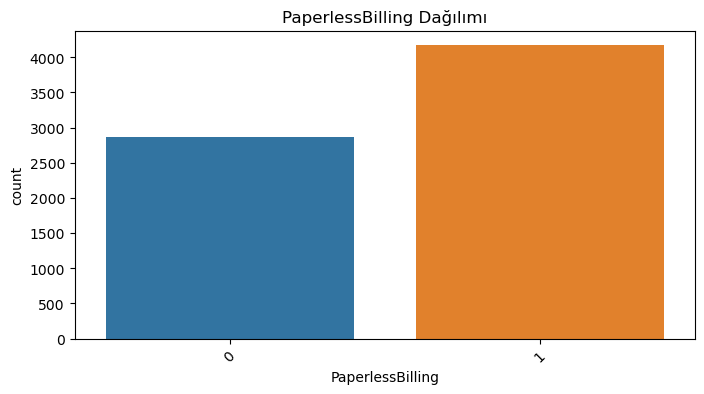

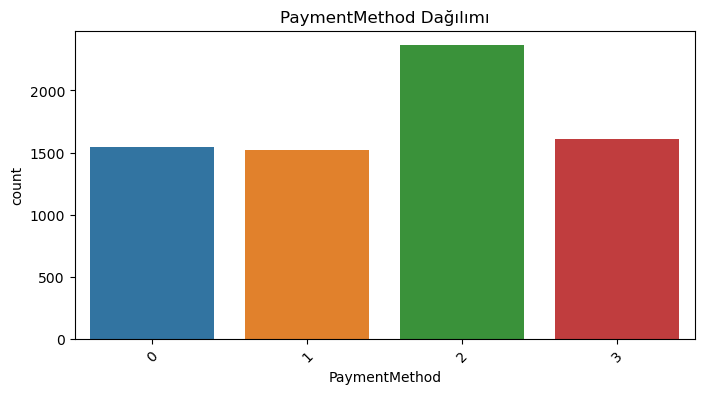

In [6]:

categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=data)
    plt.xticks(rotation=45)
    plt.title(f'{col} Dağılımı')
    plt.show()

Kategorik Değişkenlerle Müşteri Kaybı Arasındaki İlişki

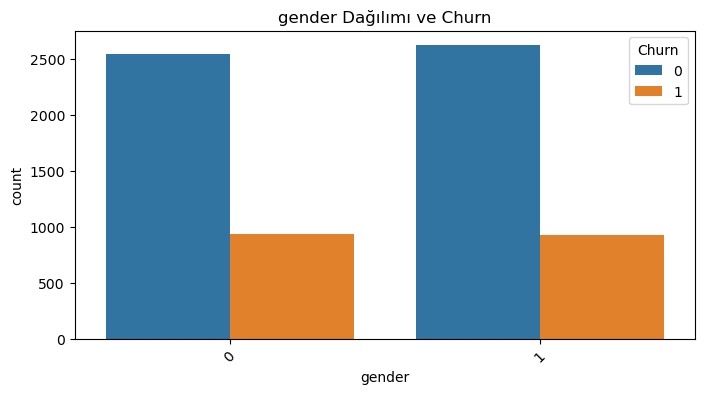

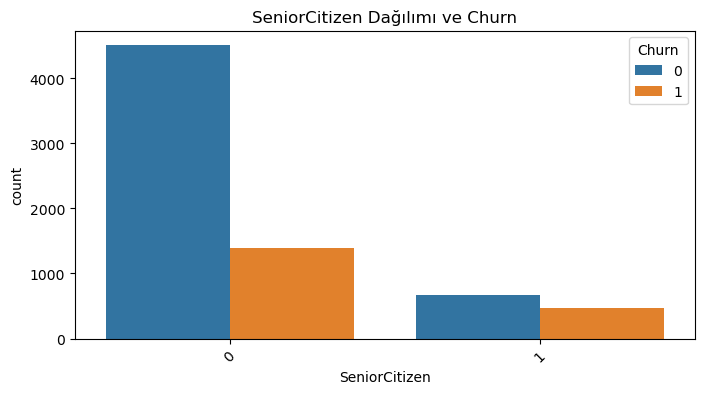

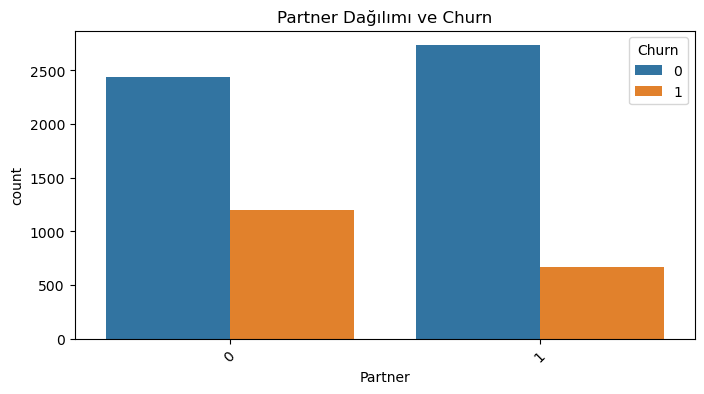

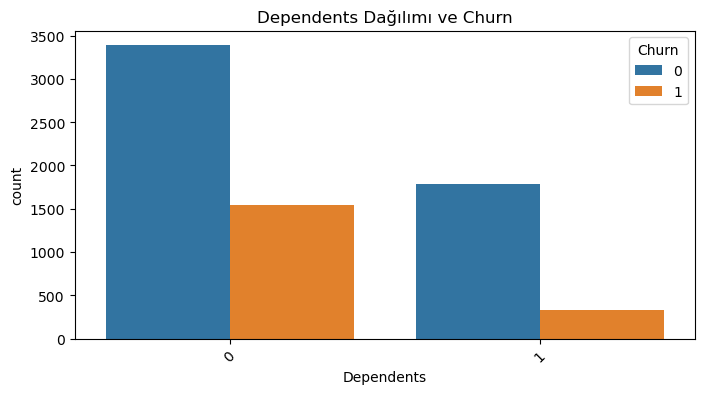

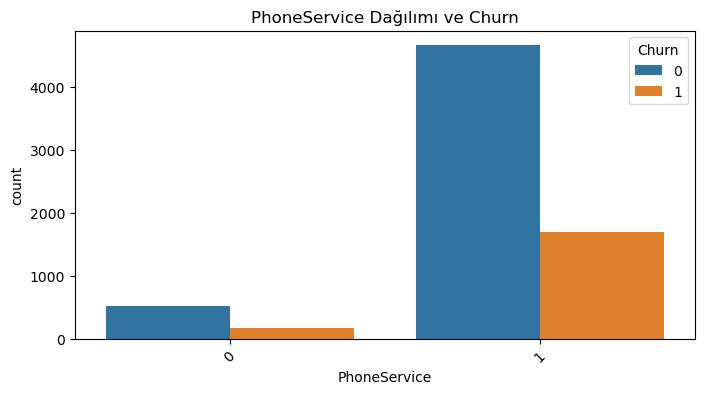

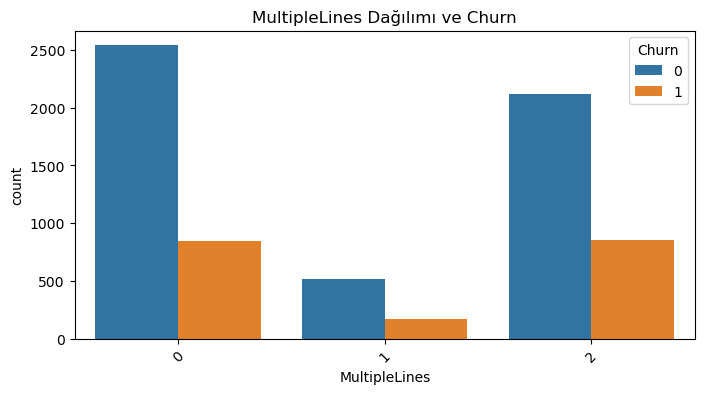

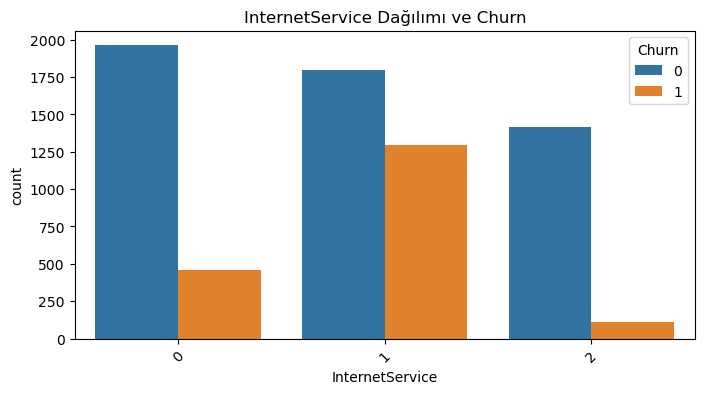

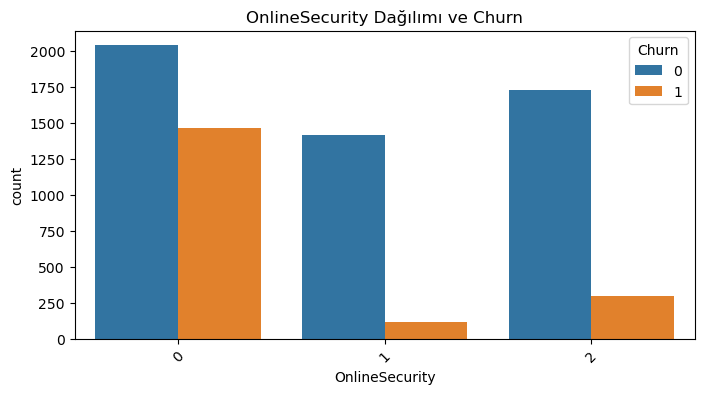

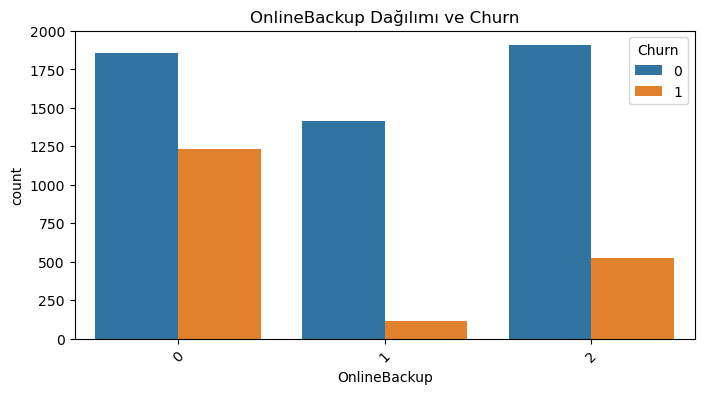

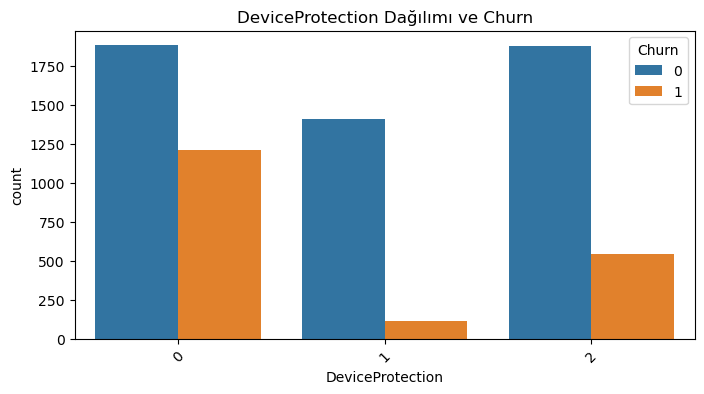

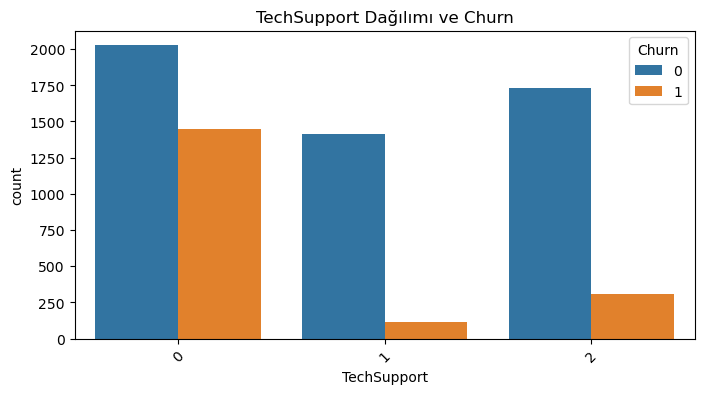

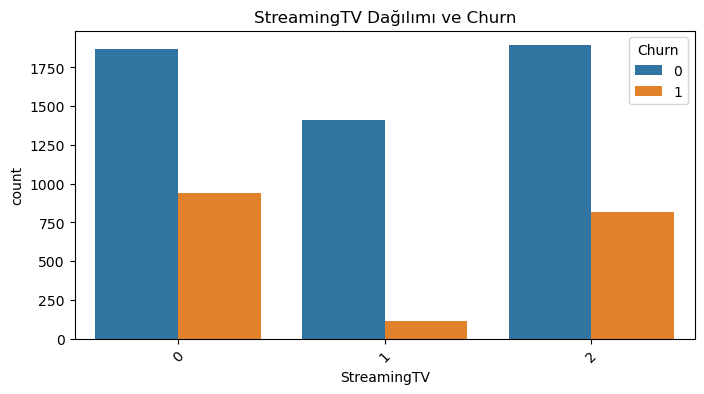

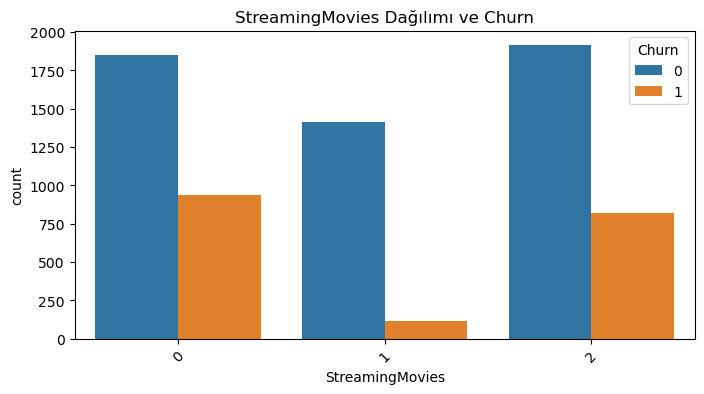

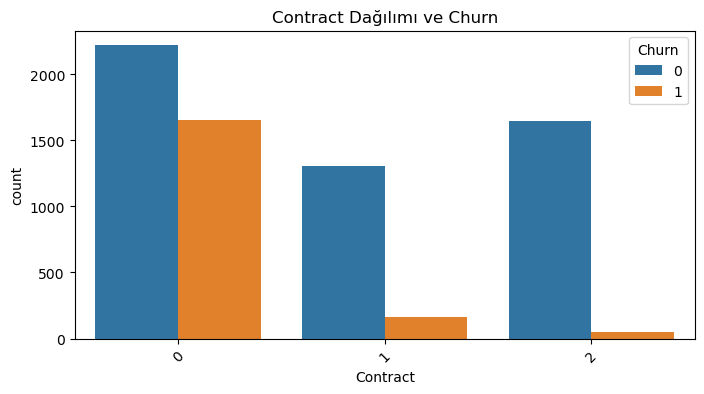

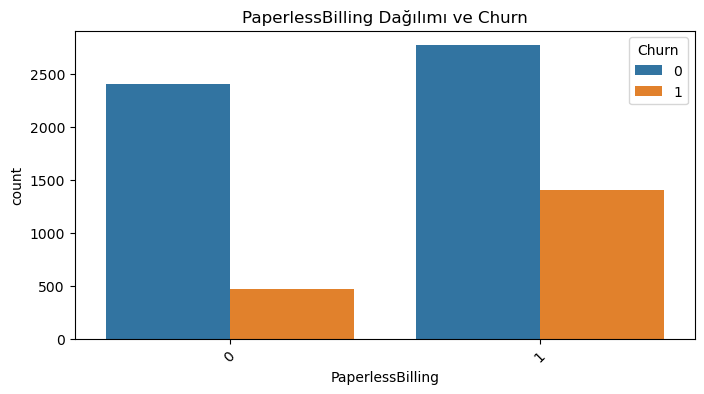

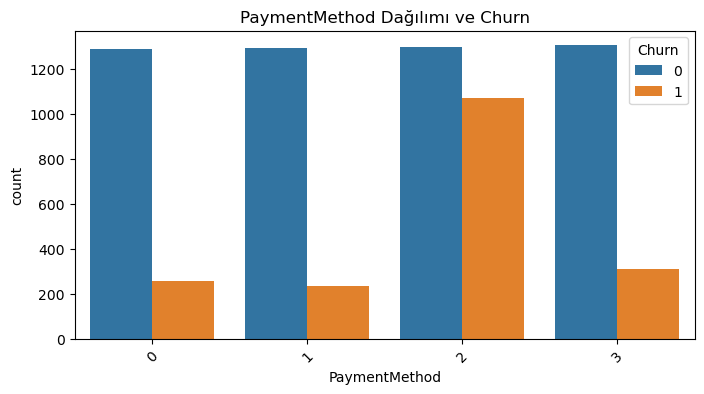

In [7]:
# Kategorik değişkenlerle müşteri kaybı arasındaki ilişkiyi inceleyin
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Churn', data=data)
    plt.xticks(rotation=45)
    plt.title(f'{col} Dağılımı ve Churn')
    plt.show()

Sayısal Değişkenlerle Müşteri Kaybı Arasındaki İlişki

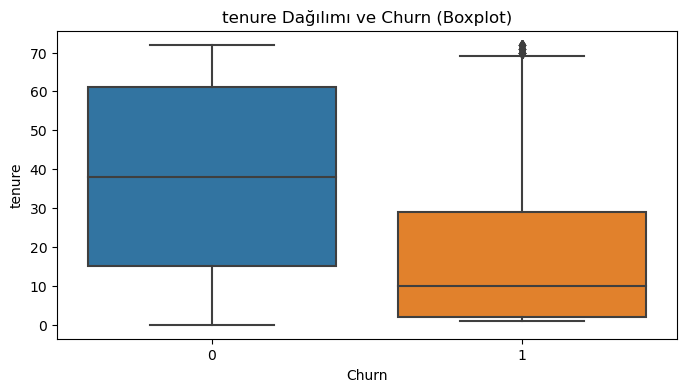

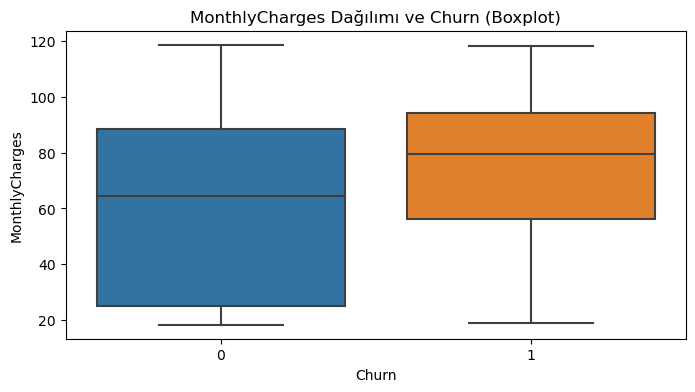

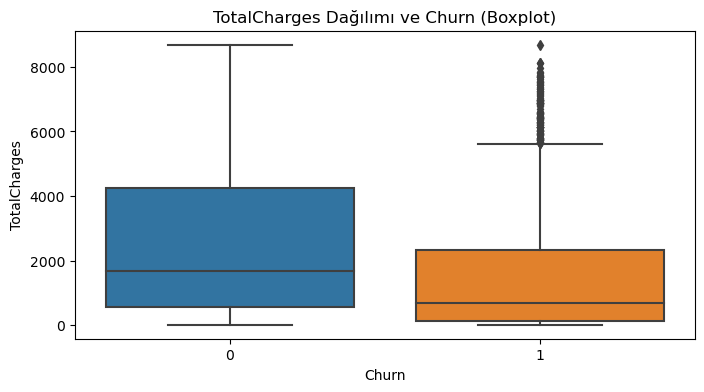

In [8]:
# Sayısal değişkenlerle müşteri kaybı arasındaki ilişkiyi inceleyin
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Churn', y=col, data=data)
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.title(f'{col} Dağılımı ve Churn (Boxplot)')
    plt.show()

Log Dönüşümü ve Analiz

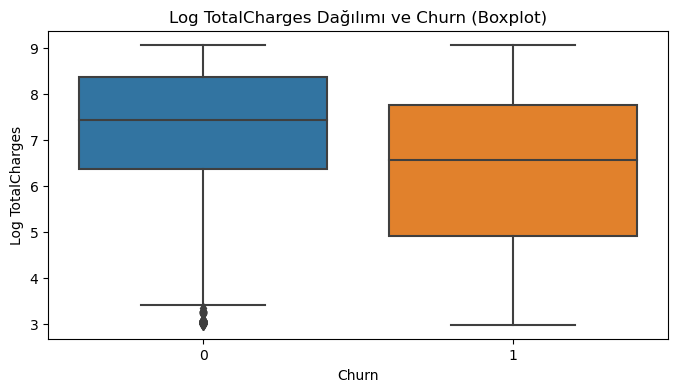

In [7]:
# Log dönüşümü uygulama
data['TotalCharges_log'] = np.log1p(data['TotalCharges'])

# Log TotalCharges ile müşteri kaybı arasındaki ilişki
plt.figure(figsize=(8, 4))
sns.boxplot(x='Churn', y='TotalCharges_log', data=data)
plt.xlabel('Churn')
plt.ylabel('Log TotalCharges')
plt.title('Log TotalCharges Dağılımı ve Churn (Boxplot)')
plt.show()

In [8]:
# Normalizasyon işlemi
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])


X = data.drop(columns=['customerID', 'Churn']).values
y = data['Churn'].values


X_lstm = X.reshape(X.shape[0], 1, X.shape[1]).astype(np.float32)  
X_cnn = X.reshape(X.shape[0], X.shape[1], 1).astype(np.float32) 
X_basic = X.astype(np.float32)  


X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42, stratify=y)
X_train_cnn, X_test_cnn, _, _ = train_test_split(X_cnn, y, test_size=0.2, random_state=42, stratify=y)
X_train_basic, X_test_basic, _, _ = train_test_split(X_basic, y, test_size=0.2, random_state=42, stratify=y)


y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)


from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))


print("Eğitim setindeki sınıf dağılımı:")
print(np.unique(y_train, return_counts=True))


results = []
confusion_matrices = {}


def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss Over Epochs')

    # Accuracy grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()


from tensorflow.keras.callbacks import EarlyStopping

def train_and_evaluate_model(model_fn, model_name, X_train, y_train, X_test, y_test, batch_size=64, epochs=100):
    model = model_fn()
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, mode='min', restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0, class_weight=class_weights_dict)
    
    # Modelin performansını test setinde değerlendirin
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    precision = report['1']['precision'] if '1' in report else 0.0
    recall = report['1']['recall'] if '1' in report else 0.0
    f1_score = report['1']['f1-score'] if '1' in report else 0.0

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })

    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1_score:.4f}")
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_matrices[model_name], model_name)
    plot_training_history(history, model_name)
    return model, history


Eğitim setindeki sınıf dağılımı:
(array([0, 1]), array([4139, 1495], dtype=int64))


In [9]:
from keras.layers import GlobalMaxPooling1D
# LSTM Model
def lstm_model():
    model = Sequential()
    model.add(LSTM(256, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MLP Model
def mlp_model():
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_basic.shape[1], activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# CNN Model
def cnn_model():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# RNN Model
def rnn_model():
    model = Sequential()
    model.add(SimpleRNN(256, input_shape=(1, X_train_lstm.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Autoencoder Tabakalı Model
def autoencoder_model():
    input_dim = X_train_basic.shape[1]
    encoding_dim = 128

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
    encoder = Dense(int(encoding_dim / 4), activation='relu')(encoder)
    decoder = Dense(int(encoding_dim / 4), activation='relu')(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='relu')(decoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    encoder_for_classification = Model(inputs=input_layer, outputs=encoder)

    classifier = Sequential()
    classifier.add(encoder_for_classification)
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(32, activation='relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

# Derin (Deep) Autoencoder Model
def deep_autoencoder_model():
    input_dim = X_train_basic.shape[1]
    encoding_dim = 256

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
    encoder = Dense(int(encoding_dim / 4), activation='relu')(encoder)
    encoder = Dense(int(encoding_dim / 8), activation='relu')(encoder)
    decoder = Dense(int(encoding_dim / 8), activation='relu')(encoder)
    decoder = Dense(int(encoding_dim / 4), activation='relu')(decoder)
    decoder = Dense(int(encoding_dim / 2), activation='relu')(decoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    encoder_for_classification = Model(inputs=input_layer, outputs=encoder)

    classifier = Sequential()
    classifier.add(encoder_for_classification)
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(32, activation='relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

# Boltzmann Machine Tarzı Model
def boltzmann_machine_model():
    input_dim = X_train_basic.shape[1]
    encoding_dim = 128

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=l2(1e-5))(input_layer)
    encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
    encoded = Dense(int(encoding_dim / 4), activation='relu')(encoded)
    decoded = Dense(int(encoding_dim / 4), activation='relu')(encoded)
    decoded = Dense(int(encoding_dim / 2), activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    encoder_for_classification = Model(input_layer, encoded)

    classifier = Sequential()
    classifier.add(encoder_for_classification)
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(32, activation='relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier




Training and evaluating LSTM Model




45/45 [==============================] - 1s 2ms/step
LSTM Model - Accuracy: 0.7601, F1 Score: 0.6194


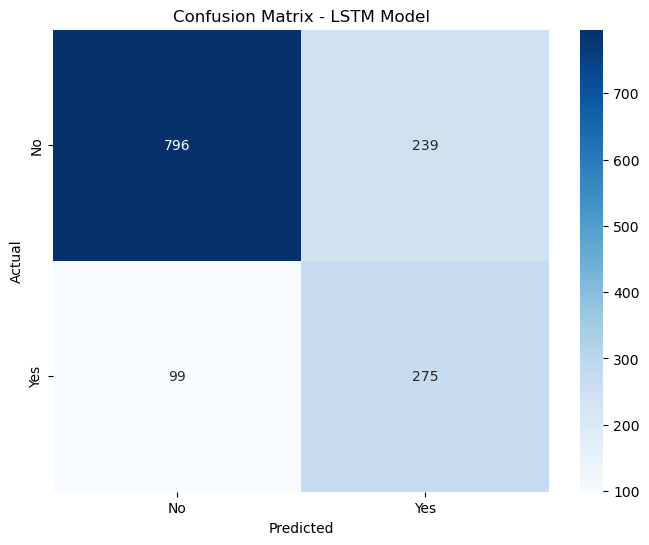

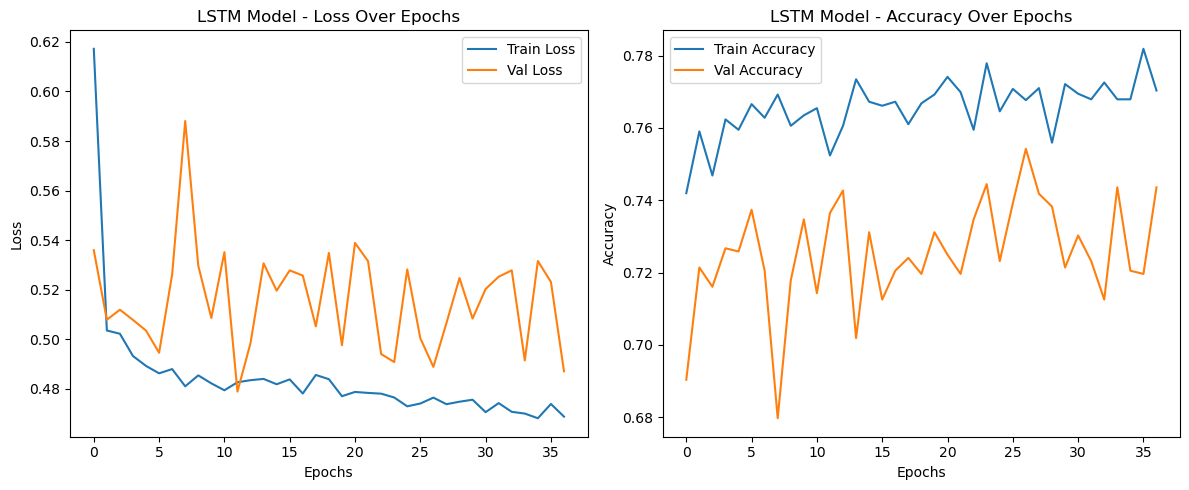


Training and evaluating MLP Model
45/45 [==============================] - 0s 862us/step
MLP Model - Accuracy: 0.7601, F1 Score: 0.6194


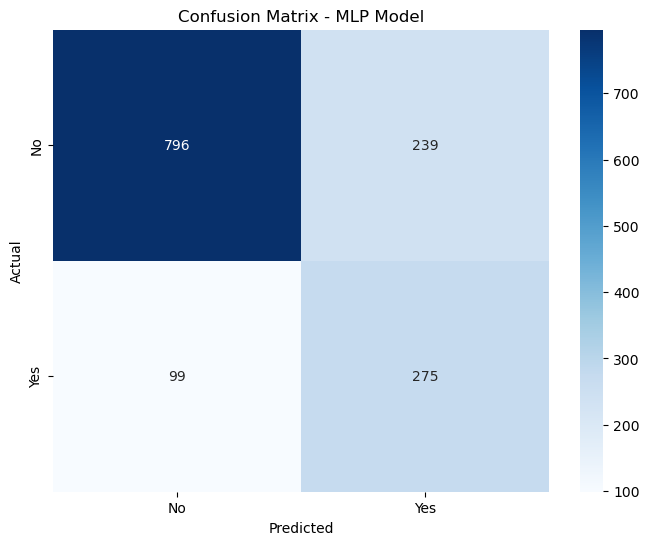

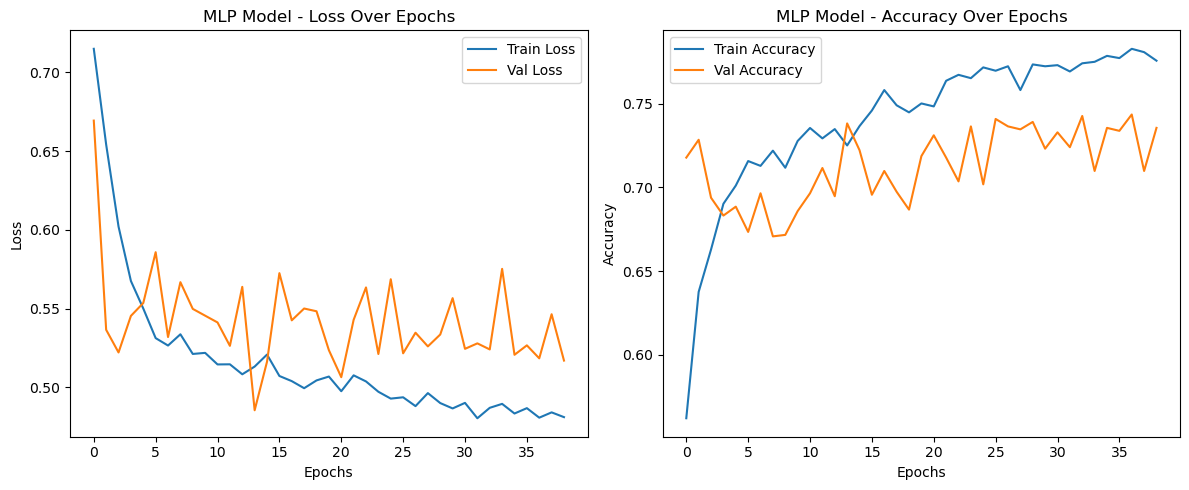


Training and evaluating Bidirectional LSTM Model
45/45 [==============================] - 2s 2ms/step
Bidirectional LSTM Model - Accuracy: 0.7672, F1 Score: 0.6230


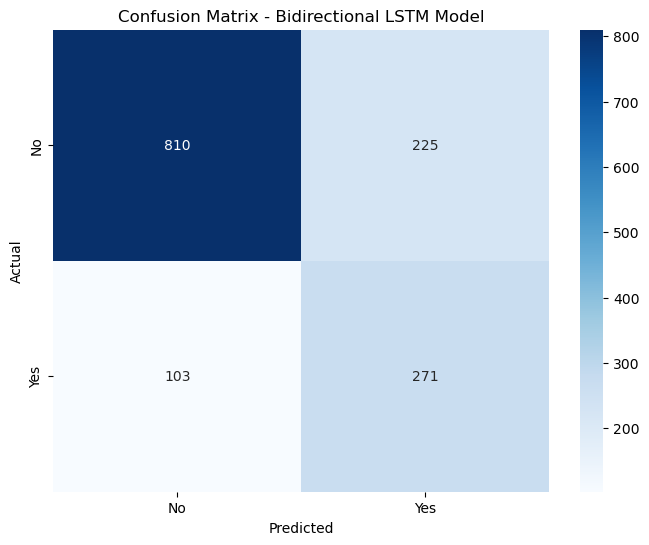

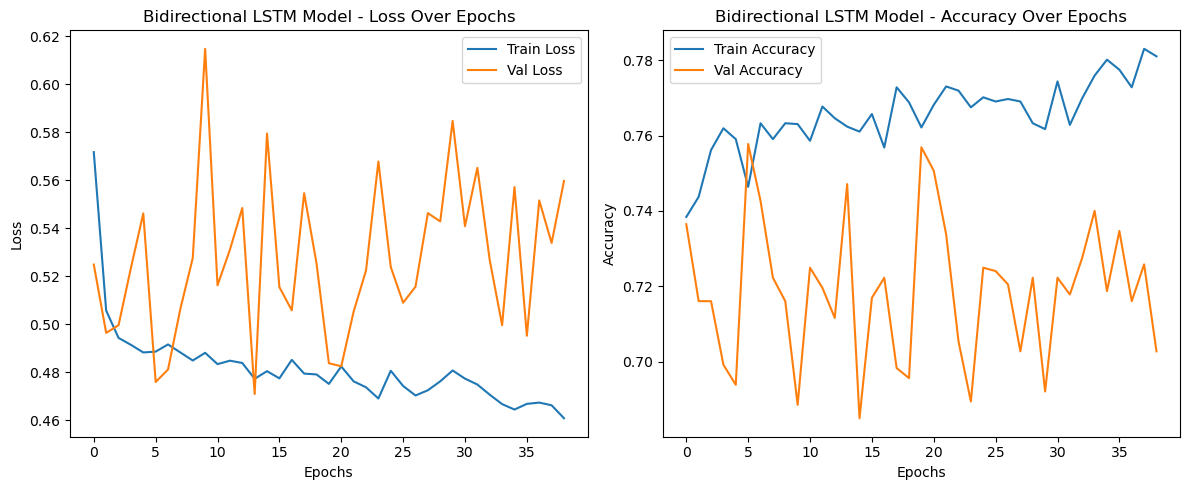


Training and evaluating CNN Model
45/45 [==============================] - 0s 1ms/step
CNN Model - Accuracy: 0.7644, F1 Score: 0.6236


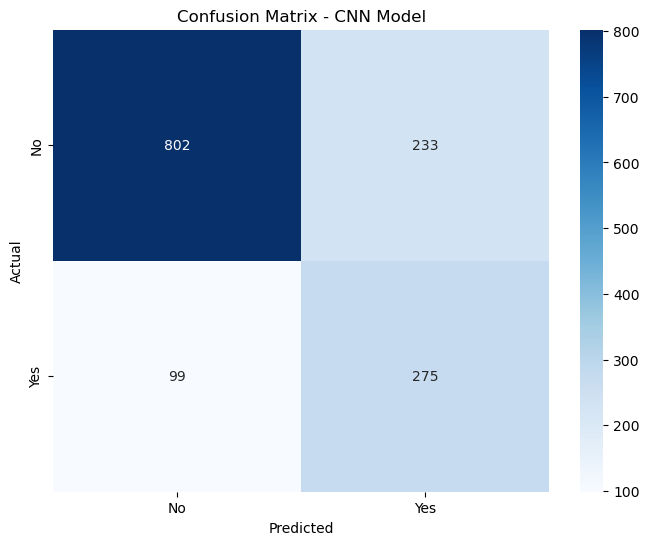

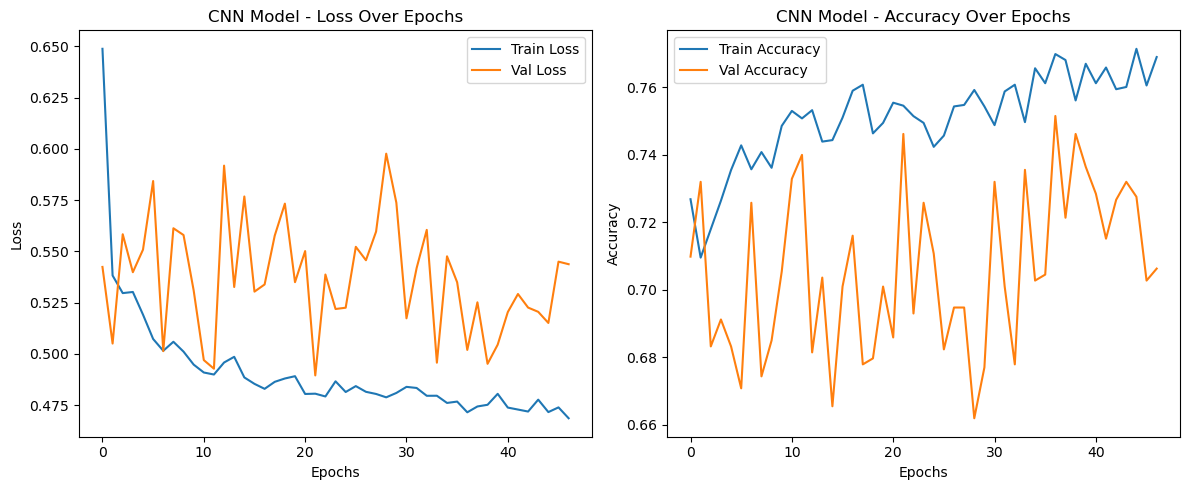


Training and evaluating RNN Model
45/45 [==============================] - 0s 1ms/step
RNN Model - Accuracy: 0.7665, F1 Score: 0.6188


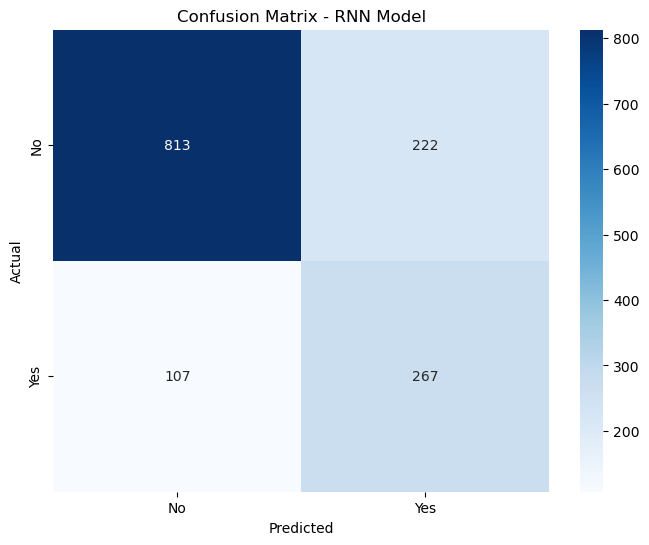

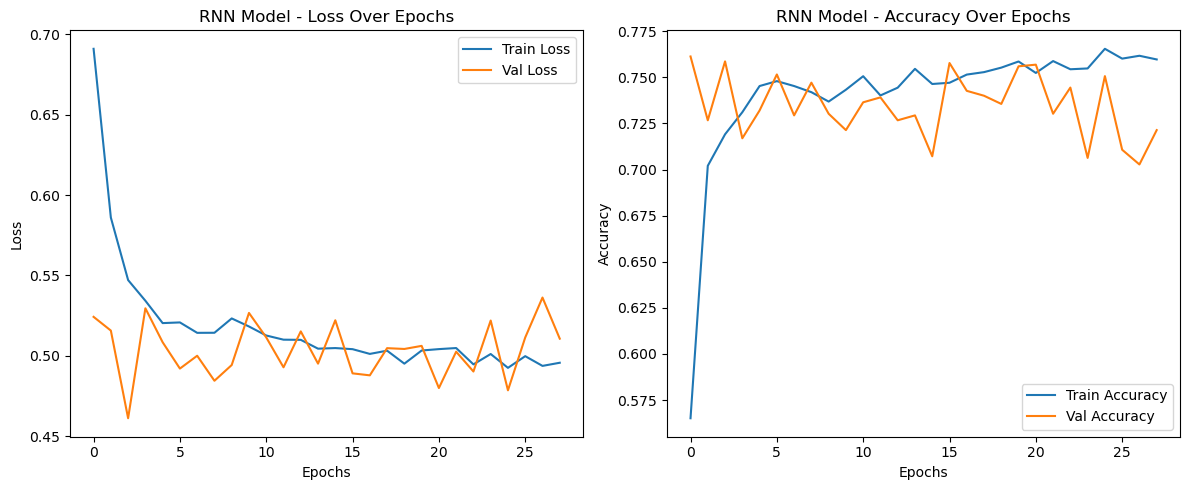


Training and evaluating Autoencoder Model
45/45 [==============================] - 0s 911us/step
Autoencoder Model - Accuracy: 0.7807, F1 Score: 0.6227


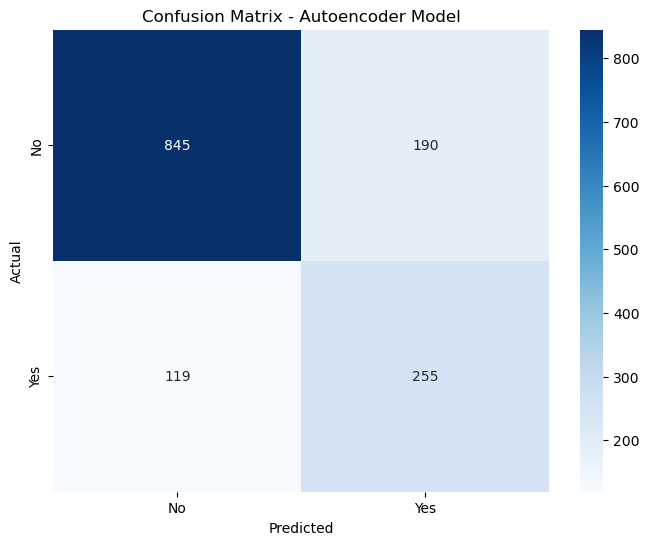

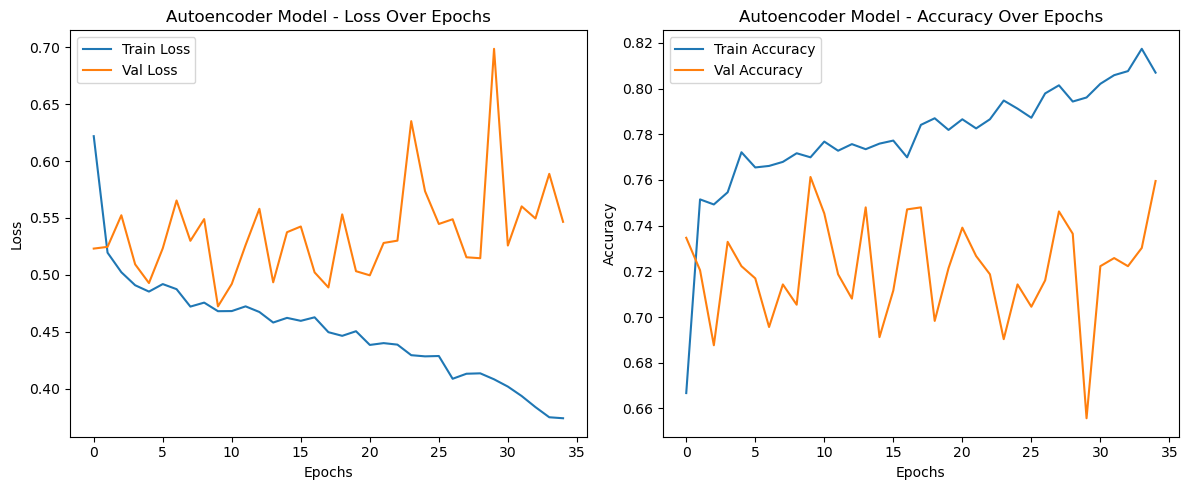


Training and evaluating Deep Autoencoder Model
45/45 [==============================] - 0s 773us/step
Deep Autoencoder Model - Accuracy: 0.7871, F1 Score: 0.6287


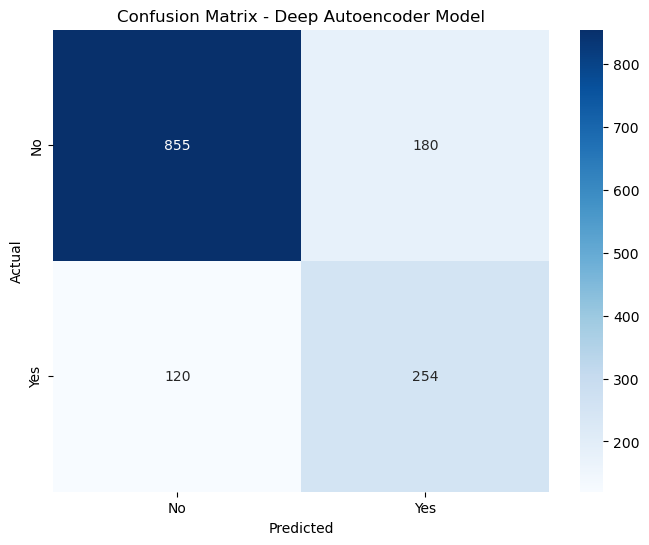

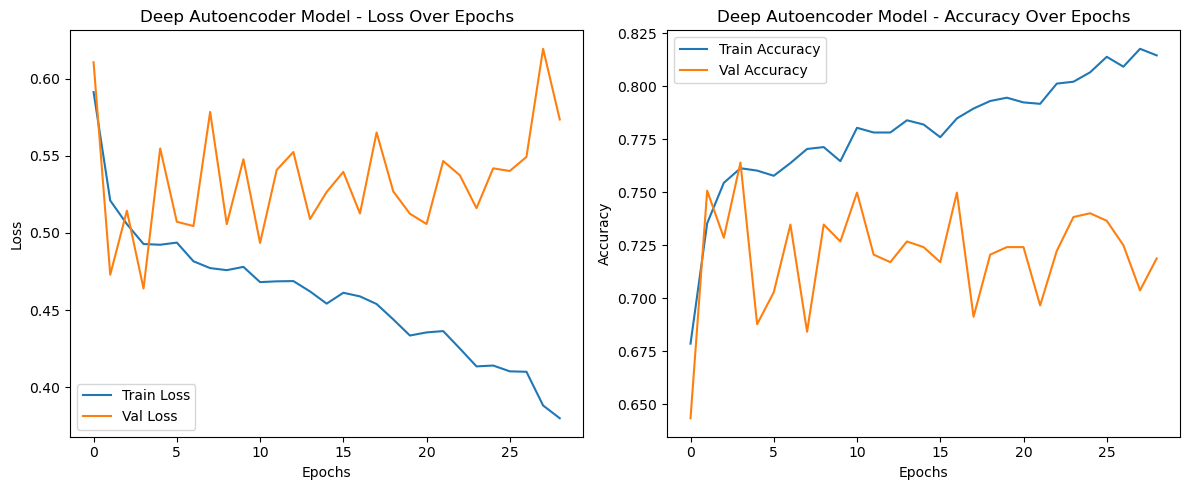


Training and evaluating Boltzmann Machine Model
45/45 [==============================] - 0s 775us/step
Boltzmann Machine Model - Accuracy: 0.7899, F1 Score: 0.6346


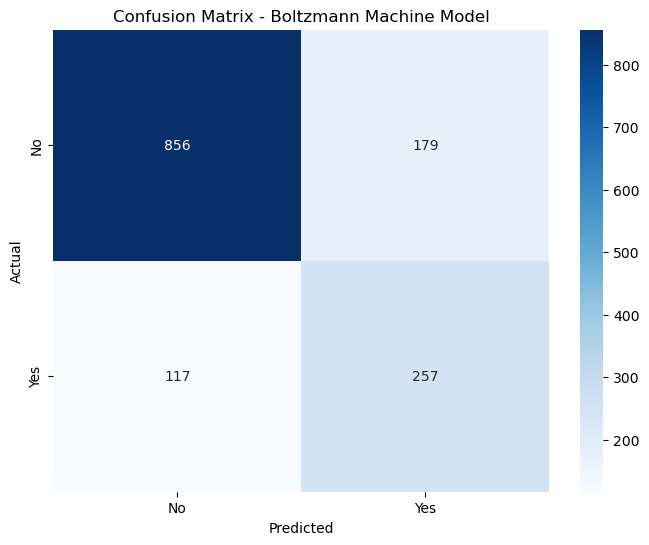

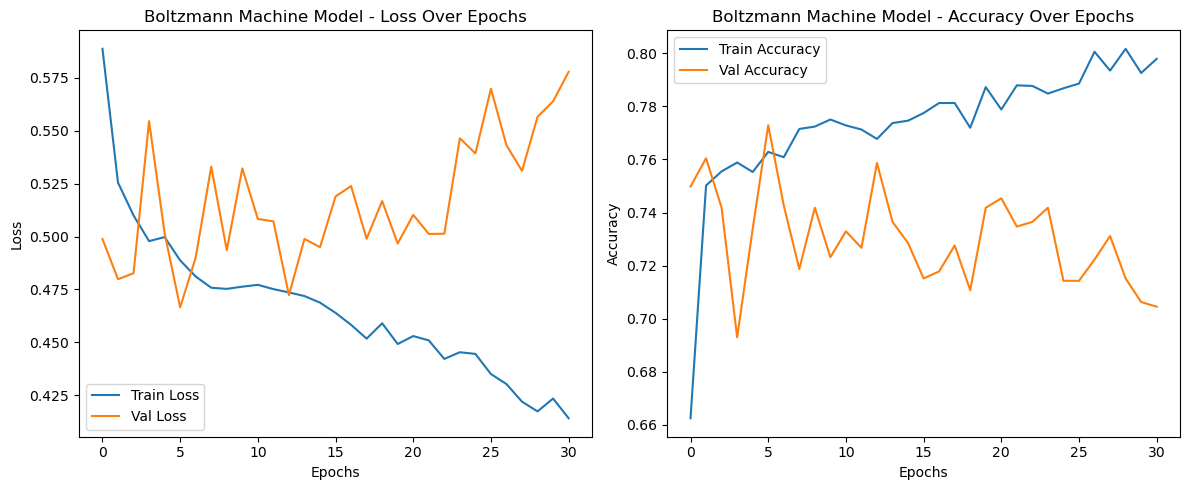


Summary of Model Performance:
LSTM Model - Accuracy: 0.7601, Precision: 0.5350, Recall: 0.7353, F1 Score: 0.6194
MLP Model - Accuracy: 0.7601, Precision: 0.5350, Recall: 0.7353, F1 Score: 0.6194
Bidirectional LSTM Model - Accuracy: 0.7672, Precision: 0.5464, Recall: 0.7246, F1 Score: 0.6230
CNN Model - Accuracy: 0.7644, Precision: 0.5413, Recall: 0.7353, F1 Score: 0.6236
RNN Model - Accuracy: 0.7665, Precision: 0.5460, Recall: 0.7139, F1 Score: 0.6188
Autoencoder Model - Accuracy: 0.7807, Precision: 0.5730, Recall: 0.6818, F1 Score: 0.6227
Deep Autoencoder Model - Accuracy: 0.7871, Precision: 0.5853, Recall: 0.6791, F1 Score: 0.6287
Boltzmann Machine Model - Accuracy: 0.7899, Precision: 0.5894, Recall: 0.6872, F1 Score: 0.6346


In [10]:
# Tüm modelleri eğit ve değerlendir
models = {
    "LSTM Model": (lstm_model, X_train_lstm, X_test_lstm),
    "MLP Model": (mlp_model, X_train_basic, X_test_basic),
    "Bidirectional LSTM Model": (bidirectional_lstm_model, X_train_lstm, X_test_lstm),
    "CNN Model": (cnn_model, X_train_cnn, X_test_cnn),
    "RNN Model": (rnn_model, X_train_lstm, X_test_lstm),
    "Autoencoder Model": (autoencoder_model, X_train_basic, X_test_basic),
    "Deep Autoencoder Model": (deep_autoencoder_model, X_train_basic, X_test_basic),
    "Boltzmann Machine Model": (boltzmann_machine_model, X_train_basic, X_test_basic)
}

for model_name, (model_fn, X_train, X_test) in models.items():
    print(f"\nTraining and evaluating {model_name}")
    train_and_evaluate_model(model_fn, model_name, X_train, y_train, X_test, y_test)

# Sonuçların özeti
print("\nSummary of Model Performance:")
for result in results:
    print(f"{result['Model']} - Accuracy: {result['Accuracy']:.4f}, Precision: {result['Precision']:.4f}, Recall: {result['Recall']:.4f}, F1 Score: {result['F1 Score']:.4f}")

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score


all_results = []


def cross_validate_model(model_fn, model_name, X, y, n_splits=5, batch_size=64, epochs=100):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nTraining fold {fold}/{n_splits} for {model_name}")
        X_train, X_val = X[train_idx], X[test_idx]
        y_train, y_val = y[train_idx], y[test_idx]

        model = model_fn()
        early_stopping = EarlyStopping(monitor='val_loss', patience=25, mode='min', restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                            callbacks=[early_stopping], verbose=0, class_weight=class_weights_dict)

        y_pred = (model.predict(X_val) > 0.5).astype("int32")
        accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)

        precision = report['1']['precision'] if '1' in report else 0.0
        recall = report['1']['recall'] if '1' in report else 0.0
        f1_score = report['1']['f1-score'] if '1' in report else 0.0

        fold_results.append({
            'Fold': fold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        })

        print(f"{model_name} - Fold {fold} - Accuracy: {accuracy:.4f}, F1 Score: {f1_score:.4f}")

    
    avg_results = {
        'Model': model_name,
        'Accuracy': np.mean([result['Accuracy'] for result in fold_results]),
        'Precision': np.mean([result['Precision'] for result in fold_results]),
        'Recall': np.mean([result['Recall'] for result in fold_results]),
        'F1 Score': np.mean([result['F1 Score'] for result in fold_results])
    }

    all_results.append(avg_results)


cross_validation_models = {
    "LSTM Model": (lstm_model, X_lstm),
    "MLP Model": (mlp_model, X_basic),
    "Bidirectional LSTM Model": (bidirectional_lstm_model, X_lstm),
    "CNN Model": (cnn_model, X_cnn),
    "RNN Model": (rnn_model, X_lstm),
    "Autoencoder Model": (autoencoder_model, X_basic),
    "Deep Autoencoder Model": (deep_autoencoder_model, X_basic),
    "Boltzmann Machine Model": (boltzmann_machine_model, X_basic)
}

for model_name, (model_fn, X) in cross_validation_models.items():
    cross_validate_model(model_fn, model_name, X, y)

""
print("\nFinal Cross-Validation Results:")
for result in all_results:
    print(f"\nModel: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")


Training fold 1/5 for LSTM Model
45/45 [==============================] - 1s 2ms/step
LSTM Model - Fold 1 - Accuracy: 0.7864, F1 Score: 0.6360

Training fold 2/5 for LSTM Model
45/45 [==============================] - 2s 2ms/step
LSTM Model - Fold 2 - Accuracy: 0.7764, F1 Score: 0.6163

Training fold 3/5 for LSTM Model
45/45 [==============================] - 1s 2ms/step
LSTM Model - Fold 3 - Accuracy: 0.7899, F1 Score: 0.6590

Training fold 4/5 for LSTM Model
44/44 [==============================] - 1s 2ms/step
LSTM Model - Fold 4 - Accuracy: 0.7493, F1 Score: 0.6082

Training fold 5/5 for LSTM Model
44/44 [==============================] - 1s 2ms/step
LSTM Model - Fold 5 - Accuracy: 0.7706, F1 Score: 0.5843

Training fold 1/5 for MLP Model
45/45 [==============================] - 0s 905us/step
MLP Model - Fold 1 - Accuracy: 0.7509, F1 Score: 0.6254

Training fold 2/5 for MLP Model
45/45 [==============================] - 0s 891us/step
MLP Model - Fold 2 - Accuracy: 0.7786, F1 Score:

In [12]:
# Tüm sonuçları ekrana yazdırın
print("\nFinal Cross-Validation Results:")
for result in all_results:
    print(f"\nModel: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")


Final Cross-Validation Results:

Model: LSTM Model
Accuracy: 0.7745
Precision: 0.5615
Recall: 0.6972
F1 Score: 0.6208

Model: MLP Model
Accuracy: 0.7623
Precision: 0.5394
Recall: 0.7330
F1 Score: 0.6209

Model: Bidirectional LSTM Model
Accuracy: 0.7772
Precision: 0.5671
Recall: 0.6800
F1 Score: 0.6184

Model: CNN Model
Accuracy: 0.7751
Precision: 0.5637
Recall: 0.6982
F1 Score: 0.6218

Model: RNN Model
Accuracy: 0.7582
Precision: 0.5324
Recall: 0.7533
F1 Score: 0.6230

Model: Autoencoder Model
Accuracy: 0.7819
Precision: 0.5781
Recall: 0.6715
F1 Score: 0.6204

Model: Deep Autoencoder Model
Accuracy: 0.7821
Precision: 0.5780
Recall: 0.6629
F1 Score: 0.6167

Model: Boltzmann Machine Model
Accuracy: 0.7775
Precision: 0.5694
Recall: 0.6618
F1 Score: 0.6115
